# Monte Carlo Valuation of Financial Derivatives
We'll be trying the  Valuation of Financial Derivatives through Monte Carlo Simulations and that's only possible by using the Financial Mathematics of Risk-Neutral Pricing and simulating risk-neutral asset paths.

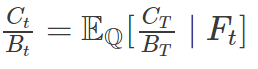

# What is Monte Carlo Simulation
A Monte Carlo simulation is used to model the probability of different outcomes in a process that cannot easily be predicted due to the intervention of random variables. It is a technique used to understand the impact of risk and uncertainty.
## How can it help us in Finance?
We can solve two types of problems using Monte Carlo Simulation.

**Portfolio Statistics** :  (Brownian Motion is representative of Real probabilities under P-measure)    
– Expected returns    
– Risk metrics (VaR, CVaR, …)    
– Downside risks (Drawdown metrics,…)    
– other probabilities of interest    

**Derivatives Pricing with risk-neutral pricing** :  (Brownian Motion is representative of risk-neutral probabilities under Q-measure)



In [10]:
# Importing Libraries
import math
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data as pdr

In [11]:
# Getting the data
yf.pdr_override()
stockList = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO']
stocks = [stock + '.AX' for stock in stockList]
endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=300)
stockData = pdr.get_data_yahoo(stocks,startDate,endDate)
stockData = stockData['Close']
returns = stockData.pct_change()
meanReturns = returns.mean()
covMatrix = returns.cov()

[*********************100%%**********************]  6 of 6 completed


In [12]:
weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

In [16]:
# Monte Carlo Simulation
nb_sims = 400  # number of simulations
T = 100  #number of days in Simulation
meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T
portfolio_sims = np.full(shape=(T,nb_sims), fill_value=0.0)
initialPortfolio = 10000
for m in range(0, nb_sims):
    Z = np.random.normal(size=(T, len(weights))) #uncorrelated RV's
    L = np.linalg.cholesky(covMatrix) #Cholesky decomposition to Lower Triangular Matrix
    dailyReturns = meanM + np.inner(L, Z) #Correlated daily returns for individual stocks
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

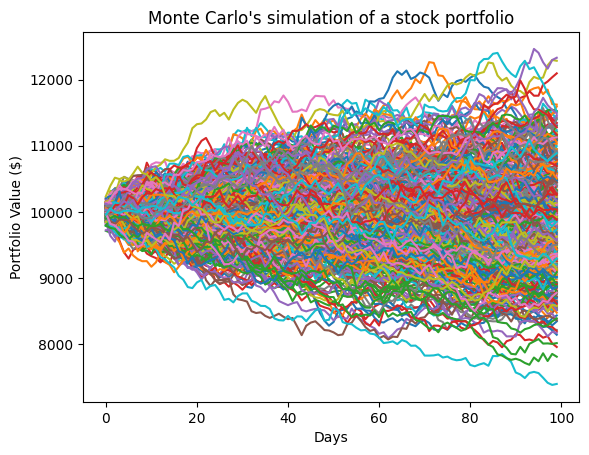

In [17]:
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title("Monte Carlo's simulation of a stock portfolio")
plt.show()

## How do assess the work done?
### What is VaR ?

Value at risk (VaR) is a statistic that quantifies the extent of possible financial losses within a firm, portfolio, or position over a specific time frame. This metric is most commonly used by investment and commercial banks to determine the extent and probabilities of potential losses in their institutional portfolios.

**VaR = Market Price * Volatility**

### What is CVaR?

Conditional Value at Risk (CVaR), also known as the expected shortfall, is a risk assessment measure that quantifies the amount of tail risk an investment portfolio has. CVaR is derived by taking a weighted average of the “extreme” losses in the tail of the distribution of possible returns, beyond the value at risk (VaR) cutoff point. Conditional value at risk is used in portfolio optimization for effective risk management.

**For complex distributions or large portfolios, Monte Carlo simulation can be used to estimate CVaR by simulating a large number of potential market scenarios and calculating the average loss in the worst-case scenarios.**

###Comparison Between CVaR and Value at Risk (VaR)

While both CVaR and VaR are essential risk management tools, CVaR provides a more detailed view of the tail risk by focusing on the average loss in the worst-case scenarios.

This makes CVaR a more conservative and robust measure, which is particularly useful for capturing the risk of assets with non-normal distributions and fat tails.

In [22]:
def mcVaR(returns, alpha=3):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")
def mcCVaR(returns, alpha=3):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")
portResults = pd.Series(portfolio_sims[-1,:])
VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)
print('VaR_5 ${}'.format(round(VaR,2)))
print('CVaR_5 ${}'.format(round(CVaR,2)))

VaR_5 $1421.21
CVaR_5 $1724.65


## Compared to other deterministic methods Monte Carlo is inefficient in it’s basic form
In any case, we can improve the accuracy by using:

**1. Variance Reduction Methods**:     
– Antithetic Variates    
– Control Variates

**2. Quasi-random numbers (deterministic series) compared to pseudo random numbers.**


# Valuation by Simulation
The risk-neutral pricing methodology tells us that: value of an

***option = risk-neutral expectation of its discounted payoff***

We can estimate this expectation by computing the average of a large number of discounted payoffs. For a particular simulation i:

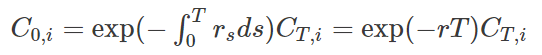

Now if we repeat the simulation M times, we can average the outcomes

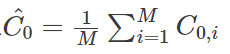

Where this mean is the estimation of the true value of the option.

an important factor as well is the standard error which can be estimated as the following:

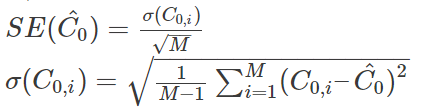


# European Call Option in the Black-Scholes World
Here we have constant interest rate so the discount factor is **exp(-rT)** and **Geometric Brownian Motion (GBM)**
Let’s simulate this GBM process by simulating variables of the natural logarithm process of the stock price

##***xt=ln(St)***

using Ito's Calculus we get to the following formula :    

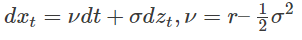

We can then discretize the Stochastic Differential Equation (SDE) by changing the infinitesimals dx,dt,dz into small steps Δx,Δt,Δz.

This is the exact solution to the SDE and involves no approximation.

##xt+Δt=xt+ν(Δt)+σ(zt+Δt−zt)

In terms of the stock price S, we have:

##St+Δt=Stexp(νΔt+σ(zt+Δt−zt))

Where (zt+Δt−zt)∼N(0,Δt)∼√ΔtN(0,1)∼√Δtϵi

In [31]:
# initial derivative parameters
S = 101.15          #stock price
K = 98.01           #strike price
vol = 0.0991        #volatility (%)
r = 0.01            #risk-free rate (%)
N = 10              #number of time steps
M = 1000            #number of simulations
market_value = 3.86 #market price of option
T = ((datetime.date(2023,8,17)-datetime.date(2023,7,17)).days+1)/365    #time in years
print(T)

0.08767123287671233


# Vectorized Solution

In [32]:
#precomputing constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)
# Monte Carlo Method
Z = np.random.normal(size=(N, M))
delta_lnSt = nudt + volsdt*Z
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt ) )
# Compute Expectation and SE
ST = np.exp(lnSt)
CT = np.maximum(0, ST - K)
C0 = np.exp(-r*T)*np.sum(CT[-1])/M
sigma = np.sqrt( np.sum( (CT[-1] - C0)**2) / (M-1) )
SE = sigma/np.sqrt(M)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $3.59 with SE +/- 0.09


# Visualization of Convergence

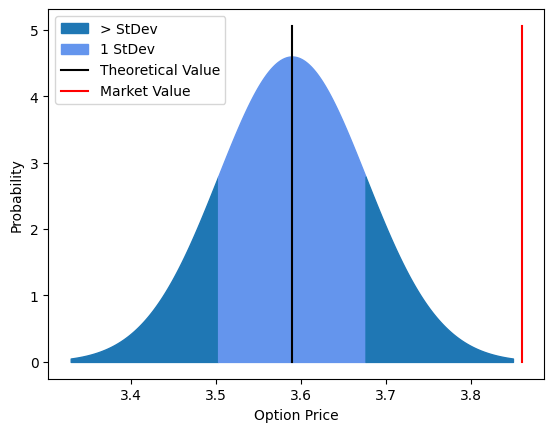

In [33]:
x1 = np.linspace(C0-3*SE, C0-1*SE, 100)
x2 = np.linspace(C0-1*SE, C0+1*SE, 100)
x3 = np.linspace(C0+1*SE, C0+3*SE, 100)
s1 = stats.norm.pdf(x1, C0, SE)
s2 = stats.norm.pdf(x2, C0, SE)
s3 = stats.norm.pdf(x3, C0, SE)
plt.fill_between(x1, s1, color='tab:blue',label='> StDev')
plt.fill_between(x2, s2, color='cornflowerblue',label='1 StDev')
plt.fill_between(x3, s3, color='tab:blue')
plt.plot([C0,C0],[0, max(s2)*1.1], 'k',
        label='Theoretical Value')
plt.plot([market_value,market_value],[0, max(s2)*1.1], 'r',
        label='Market Value')
plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()